In [1]:
import numpy as np
import zeus
from astropy.io import fits
import matplotlib.pyplot as plt
import pyccl as ccl 
import jax
import jax.numpy as jnp

In [3]:
Om0 = 0.3166
Ob0 = 0.049
H0 = 70.0
sigma8 = 0.82
ns = 0.967
transferFunction = 'boltzmann_camb'

In [4]:
cosmoModel=ccl.Cosmology(Omega_c = Om0-Ob0, Omega_b = Ob0, h = 0.01*H0, sigma8 = sigma8, n_s = ns,
                            transfer_function = transferFunction)
mf = ccl.halos.hmfunc.tinker10.MassFuncTinker10(mass_def = '500c')
cm = ccl.halos.concentration.ishiyama21.ConcentrationIshiyama21(mass_def = '500c')

In [5]:
def concentration(mass, redshift, cosmology):
    return cm(cosmoModel, mass, redshift)
vectorized_cm = jax.vmap(concentration, in_axes=(0,0,None))

In [6]:
def MDef1ToMDef2(mass, z, MDef1, MDef2, cosmoModel, c_m_relation = 'Bhattacharya13'):
    """Convert some mass at some z defined using MDef1 into a mass defined according to MDef2.

    Args:
        mass (float): Halo mass in MSun.
        z (float): Redshift of the halo.
        MDef1 (`obj`:ccl.halos.MassDef): CCL halo mass definition you want to convert from.
        MDef2 (`obj`:ccl.halos.MassDef): CCL halo mass definition you want to convert to.
    ,   c_m_relation ('obj':`str`): Name of the concentration -- mass relation to assume, as understood by CCL.

    """

    tolerance=1e-5
    scaleFactor=3.0
    ratio=1e6
    count=0
    try:
        trans1To2=ccl.halos.mass_translator(mass_in = MDef1, mass_out = MDef2, concentration = c_m_relation)
        massX=trans1To2(cosmoModel, mass, 1/(1+z))
    except:
        trans2To1=ccl.halos.mass_translator(mass_in = MDef2, mass_out = MDef1, concentration = c_m_relation)
        while abs(1.0-ratio) > tolerance:
            testMass=trans2To1(cosmoModel, scaleFactor*mass, 1/(1+z))
            ratio=mass/testMass
            scaleFactor=scaleFactor*ratio
            count=count+1
            if count > 10:
                raise Exception("MDef1 -> MDef2 mass conversion didn't converge quickly enough")
        massX=scaleFactor*mass

    return massX

In [7]:
def calcR500Mpc(z, M500c, cosmoModel):
    """Calculate R500 (in Mpc), with respect to critical density.

    Args:
        z (float): Redshift.
        M500c (float): Mass within R500c (i.e., with respect to critical density) in units of solar masses.
        cosmoModel (`:obj:`pyccl.Cosmology`): Cosmology object.
    
    Returns:
        R500c (in Mpc)
    
    """
    
    R500Mpc=calcRDeltaMpc(z, M500c, cosmoModel, delta = 500, wrt = 'critical')
    return R500Mpc


def calcTheta500Arcmin(z, M500, cosmoModel):
    """Given `z`, `M500` (in MSun), returns the angular size equivalent to R:sub:`500c`, with respect to the
    critical density.
    
    Args:
        z (float): Redshift.
        M500 (float): Mass within R500c (i.e., with respect to critical density) in units of solar masses.
        cosmoModel (`:obj:`pyccl.Cosmology`): Cosmology object.
    
    Returns:
        theta500c (in arcmin)
    
    """
    
    R500Mpc=calcR500Mpc(z, M500, cosmoModel)
    #theta500Arcmin=np.degrees(np.arctan(R500Mpc/cosmoModel.angular_diameter_distance(z).value))*60.0
    theta500Arcmin=np.degrees(np.arctan(R500Mpc/ccl.angular_diameter_distance(cosmoModel, 1/(1+z))))*60.0
    
    return theta500Arcmin

def calcRDeltaMpc(z, MDelta, cosmoModel, delta = 500, wrt = 'critical'):
    """Calculate RDelta (e.g., R500c, R200m etc.) in Mpc, for a halo with the given mass and redshift.
    
    Args:
        z (float): Redshift.
        MDelta (float): Halo mass in units of solar masses, using the definition set by `delta` and `wrt`.
        cosmoModel (:obj:`pyccl.Cosmology`): Cosmology object.
        delta (float, optional): Overdensity (e.g., typically 500 or 200).
        wrt (str, optional): Use 'critical' or 'mean' to set the definition of density with respect to the
            critical density or mean density at the given redshift.
    
    Returns:
        RDelta (in Mpc)
    
    """

    if type(MDelta) == str:
        raise Exception("MDelta is a string - use, e.g., 1.0e+14 (not 1e14 or 1e+14)")

    Ez=ccl.h_over_h0(cosmoModel, 1/(1+z))
    if wrt == 'critical':
        wrtDensity=ccl.physical_constants.RHO_CRITICAL*(Ez*cosmoModel['h'])**2
    elif wrt == 'mean':
        wrtDensity=ccl.omega_x(cosmoModel, 1/(1+z), 'matter')*ccl.physical_constants.RHO_CRITICAL*(Ez*cosmoModel['h'])**2
    else:
        raise Exception("wrt should be either 'critical' or 'mean'")
    RDeltaMpc=np.power((3*MDelta)/(4*np.pi*delta*wrtDensity), 1.0/3.0)
        
    return RDeltaMpc

In [8]:
M200mDef=ccl.halos.MassDef(200, "matter")
M200cDef=ccl.halos.MassDef(200, "critical")
M500cDef=ccl.halos.MassDef(500, "critical")

In [9]:
convertMass = ccl.halos.mass_translator(mass_in=M200cDef, mass_out=M500cDef, 
                                       concentration=ccl.halos.ConcentrationDuffy08(mass_def=M200cDef))

In [10]:
def calcTheta500FromM200(m200c, z, cosmo, conc = "Bhattacharya"):
    m500c = convertMass(cosmo, m200c, 1/(1+z))
    return calcTheta500Arcmin(z, m500c, cosmo)


In [11]:
m200Array = np.logspace(10,16, 1000)
zArray = np.linspace(0,5,1000)
theta500Array = jnp.array([calcTheta500FromM200(m200Array, z, cosmoModel) for z in zArray])

/tmp/ipykernel_2680504/3766109296.py:34: RuntimeWarning: divide by zero encountered in divide
  theta500Arcmin=np.degrees(np.arctan(R500Mpc/ccl.angular_diameter_distance(cosmoModel, 1/(1+z))))*60.0


In [12]:
from jax.scipy.ndimage import map_coordinates
@jax.jit
def getTheta500FromM200(m200, z):
    return map_coordinates(theta500Array, [m200, z], order = 1)
vmap1 = jax.vmap(getTheta500FromM200, in_axes = (0,None))
getTheta500FromM200_vector = jax.vmap(vmap1, in_axes = (None, 0))

In [13]:
mInterpArray = jnp.array([12, 13])
zInterpArray = jnp.array([0.25, 0.5])
getTheta500FromM200(mInterpArray,zInterpArray)

Array([0.42647585, 0.3957671 ], dtype=float32)

In [14]:
@jax.jit
def cm(M, z):
        '''Duffy 2008 concentration relation, for mdef = 200c'''
        A = 5.71
        B = -0.084
        C = -0.47

        c = A * (M / 2E12)**B * (1.0 + z)**C
        
        return c

In [15]:
BCMParams = {'theta_ej': 5.0, 'mu_beta': 1.1, 'eta_star': 0.4, 'eta_cga': 0.4, 'log10_Mc0': 14, 'alpha_nt': 0.21, 'nu_z': 0, 'n_nt': 0.8, 'gamma_rhogas': 2.5, 'delta_rhogas': 7.0, 'sigma': 0.2}

In [16]:
import sys
sys.path.insert(1, './GODMAX_Mar_6/src/')
import get_BCMP_profile_jit, setup_power_spectra_jit

vmap1 = jax.vmap(cm, (0,None))
cm_vector = jax.vmap(vmap1, (None, 0))

@jax.jit
def ygodmax(m500c, z,params):
    #conc = cm(m500c, z)
    BCMParams = params

    nM = len(m500c)
    nZ = len(z)
    nC = 1

    sim_params_dict = {}
    #Default values from Shivam's Notebooks
    sim_params_dict['nfw_trunc'] = True
    sim_params_dict['gamma_rhogas'] = 2.0
    sim_params_dict['delta_rhogas'] = 7.0
    sim_params_dict['theta_co'] = 0.1
    sim_params_dict['theta_ej'] = 4.0
    sim_params_dict['neg_bhse_plus_1'] = 0.833
    sim_params_dict['mu_beta'] = 0.21
    sim_params_dict['eta_star'] = 0.3
    sim_params_dict['eta_cga'] = 0.6
    sim_params_dict['A_starcga'] = 0.09
    sim_params_dict['log10_M1_starcga'] = np.log10(2.5e11)
    sim_params_dict['epsilon_rt'] = 4.0
    sim_params_dict['log10_Mc0'] = 14.83
    sim_params_dict['nu_z'] = 0
    sim_params_dict['nu_M'] = 0
    sim_params_dict['log10_Mstar0'] = 13.0
    sim_params_dict['a_zeta'] = 0.3
    sim_params_dict['n_zeta'] = 2
    sim_params_dict['alpha_nt'] = 0.18
    sim_params_dict['beta_nt'] = 0.5
    sim_params_dict['n_nt'] = 0.8
    sim_params_dict['beam_fwhm_arcmin'] = 1.6
    sim_params_dict['k_min'], sim_params_dict['k_max'],sim_params_dict['k_nk'] = 1E-4, 1000, 400
    cosmo_params_dict = {'flat': True, 'H0': 100*cosmoModel['h'], 'Om0': cosmoModel['Omega_c']+cosmoModel['Omega_b'], 'Ob0': cosmoModel['Omega_b'], 'sigma8': cosmoModel['sigma8'], 'ns': cosmoModel['n_s'], 'w0':cosmoModel['w0']}
    sim_params_dict['cosmo'] = cosmo_params_dict
    if BCMParams != None:
        #sim_params_dict['nfw_trunc'] = BCMParams['trunc']
        #sim_params_dict['theta_co'] = BCMParams['theta_co']
        sim_params_dict['theta_ej'] = BCMParams['theta_ej']
        #sim_params_dict['neg_bhse_plus_1'] = BCMParams['neg_bhse_plus_1']
        sim_params_dict['mu_beta'] = BCMParams['mu_beta']
        sim_params_dict['gamma_rhogas'] = BCMParams['gamma_rhogas']
        sim_params_dict['delta_rhogas'] = BCMParams['delta_rhogas']
        sim_params_dict['eta_star'] = BCMParams['eta_star']
        sim_params_dict['eta_cga'] = BCMParams['eta_cga']+BCMParams['eta_star']
        #sim_params_dict['A_starcga'] = BCMParams['A_starcga']
        #sim_params_dict['M1_starcga'] = BCMParams['M1_starcga']
        #sim_params_dict['epsilon_rt'] = BCMParams['epsilon_rt']
        sim_params_dict['log10_Mc0'] = BCMParams['log10_Mc0']
        sim_params_dict['nu_z'] = BCMParams['nu_z']
        #sim_params_dict['nu_M'] = BCMParams['nu_M']
        #sim_params_dict['Mstar0'] = BCMParams['Mstar0']
        #sim_params_dict['a_zeta'] = BCMParams['a_zeta']
        #sim_params_dict['n_zeta'] = BCMParams['n_zeta']
        ###Battaglia 12 
        sim_params_dict['alpha_nt'] = BCMParams['alpha_nt']
        #sim_params_dict['beta_nt'] = BCMParams['beta_nt']
        sim_params_dict['n_nt'] = BCMParams['n_nt']

    halo_params_dict = {}
    halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 1e-4, 20, 160
    halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = jnp.min(z),jnp.max(z), nZ
    halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = jnp.min(m500c), jnp.max(m500c), nM
    halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 5, 5, nC
    halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**16, 10
    halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.25
    halo_params_dict['mdef'] = '200c'
    halo_params_dict['hmf_model'] = 'T10'
    halo_params_dict['conc_model'] = 'Prada12'
    halo_params_dict['do_corr_2h_mm'] = True
    halo_params_dict['y3D'] = True

    from astropy.io import fits
    df = fits.open('/users/PCON0003/nddalal/DESACT/GODMAX_Mar_6/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
    z_array = df['nz_source'].data['Z_MID']
    nz_info_dict = {}
    nz_info_dict['z_array'] = z_array
    nz_info_dict['nbins'] = 4
    nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-3)
    nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-3)
    nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-3)
    nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-3)
    analysis_dict = {}
    analysis_dict['nz_info_dict'] = nz_info_dict
    analysis_dict = {}
    analysis_dict['nz_info_dict'] = nz_info_dict
    analysis_dict['do_sheary'] = False
    analysis_dict['do_shearh'] = False
    analysis_dict['do_shearh_DM'] = False
    analysis_dict['do_shear2pt_DM'] = False
    analysis_dict['do_shear2pt'] = False
    analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
    analysis_dict['beam_fwhm_arcmin'] = 1.6
    analysis_dict['want_like_diff'] = True
    analysis_dict['calc_nfw_only'] = True

    df_data = fits.open('/users/PCON0003/nddalal/DESACT/GODMAX_final/data/DES_ACT_full_data_theorycov_2.5.fits')
    theta_data = df_data['compton_shear'].data['ANG'][0:20]


    analysis_dict['angles_data_array'] = jnp.array(theta_data)

    print(">>> Calculating Power")
    BC_power = get_BCMP_profile_jit.BCM_18_wP(sim_params_dict, halo_params_dict, num_points_trapz_int=64, verbose_time= True)

    setup_power = setup_power_spectra_jit.setup_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict, BCMP_obj = BC_power, verbose_time=True, doyclonly=True)
    #jax.debug.print('ycl = {}', setup_power.ycl[0][0][0])
    return (setup_power.ycl[:,:,0], setup_power.hmf_Mz_mat)

In [17]:
import yaml
#from pyDOE2 import lhs
#from Corrfunc.theory import DDrppi
import fitsio
import numpy as np
import os
import pickle
import chaospy as cp

class EmuModel():
    def __init__(self, param_ranges=None, params=None, surrogate_order=None):
        self.surrogate_order=surrogate_order
        self.param_ranges = param_ranges
        self.params = params
        if param_ranges is not None:
            distribution = cp.J(
                *[cp.Uniform(param_ranges[i][0], param_ranges[i][1]) for i in range(len(params))])
            self.pce = cp.orth_ttr(surrogate_order, distribution)
            print("PCE shape", self.pce.shape)
        self.surrogate=None

    def train(self, design, dv_sim):
        self.surrogate = cp.fit_regression(self.pce, design.T, dv_sim)
        
    @jax.jit
    def __call__(self, params):
        coeff = jnp.array(self.surrogate.coefficients)
        expon = jnp.array(self.surrogate.exponents)
        prod = jnp.prod(params**expon, axis = -1)
        #print(prod[:, jnp.newaxis]*coeff)
        prod_reshape = prod[:, jnp.newaxis]
        return jnp.sum(coeff*prod_reshape, axis =0)

    def load(self, filename):
        f = open(filename, 'rb')
        tmp_dict = pickle.load(f)
        f.close()          
        self.__dict__.update(tmp_dict) 


    def save(self, filename):
        f = open(filename, 'wb')
        pickle.dump(self.__dict__, f, 2)
        f.close()

In [18]:
l_bounds = [-1, 0, 0.01, 0.225, 0.325, 0.6,  1, 2, 3, 13]
u_bounds = [1, 2, 0.4, 0.575, 0.475, 1.0, 4, 8, 11, 15]
param_ranges = [(l_bounds[i], u_bounds[i]) for i in range(len(l_bounds))]
params = ["nu_z", "mu_beta", "alpha_nt", "eta_star", "eta_cga", "n_nt", "gamma_rhogas", "theta_ej", "delta_rhogas", "log10_Mc0"]
pdic = {}
for i in range(len(params)):
    pdic[params[i]] = param_ranges[i]

surrogate_order = 4

design = []
for i in range(50):
    with open("/fs/ess/PCON0003/nddalal/nemo-sim-kit/SmallEmu/test_{}.yml".format(i)) as stream:
        dic = yaml.safe_load(stream)
    params = dic["BCMParams"]
    design.append([params[key] for key in params.keys()])
design = np.array(design)
print(design.shape)


#dv_sim = np.array(outlist)
#print(dv_sim.shape)
emu = EmuModel()
emu.load("/fs/ess/PCON0003/nddalal/nemo-sim-kit/logarithmic_emu_Jan27.pkl")

(50, 10)


In [19]:
@jax.jit
def evalEmu(params):
    coeff = jnp.array(emu.surrogate.coefficients)
    expon = jnp.array(emu.surrogate.exponents)
    prod = jnp.prod(params**expon, axis = -1)
    #print(prod[:, jnp.newaxis]*coeff)
    prod_reshape = prod[:, jnp.newaxis]
    return jnp.exp(jnp.sum(coeff*prod_reshape, axis =0))

In [20]:
tt500 = jnp.array([ 0.1       ,  0.11234493,  0.12621384,  0.14179485,  0.15929933,
        0.17896473,  0.20105781,  0.22587826,  0.25376278,  0.28508962,
        0.32028375,  0.35982256,  0.40424242,  0.45414587,  0.51020987,
        0.57319494,  0.64395548,  0.72345135,  0.81276093,  0.91309573,
        1.02581678,  1.15245318,  1.29472275,  1.45455541,  1.6341193 ,
        1.83585024,  2.06248472,  2.31709708,  2.39623545,  2.60314117,
        2.9244972 ,  3.28552442,  3.69112022,  4.14678654,  4.65870456,
        5.23381852,  5.87992992,  6.60580334,  7.42128534,  8.33743805,
        9.3666892 , 10.52300072, 11.82205812, 13.28148328, 14.92107351,
       16.76307006, 18.83245984, 21.15731441, 23.76917072, 26.70345895,
       29.9999831 , 33.70346094, 37.86413065, 42.53843225, 47.78977326])
@jax.jit
def q(m,z, params):
    logm = jnp.log10(m)
    theta500 = getTheta500FromM200_vector(logm,z)
    orderedArray =  jnp.array([params['nu_z'], params['mu_beta'], params['alpha_nt'], params['eta_star'], 
                               params['eta_cga'], params['n_nt'], params['gamma_rhogas'],
                               params['theta_ej'], params['delta_rhogas'], params['log10_Mc0']])
    #print(orderedArray)
    qArray = evalEmu(orderedArray)
    val = jnp.interp(theta500,tt500,qArray, left = 0, right = 0)
    return val

q_vector = jax.vmap(q, in_axes=(0,0,None))


DEBUG:2025-12-10 15:02:54,585:jax._src.dispatch:181: Finished tracing + transforming convert_element_type for pjit in 0.000241756 sec
DEBUG:2025-12-10 15:02:54,586:jax._src.interpreters.pxla:1906: Compiling convert_element_type with global shapes and types [ShapedArray(float64[55])]. Argument mapping: (UnspecifiedValue,).
DEBUG:2025-12-10 15:02:54,589:jax._src.dispatch:181: Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.002466917 sec
DEBUG:2025-12-10 15:02:54,590:jax._src.compiler:170: get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
DEBUG:2025-12-10 15:02:54,590:jax._src.compiler:243: get_compile_options XLA-AutoFDO profile: using XLA-AutoFDO profile version -1
DEBUG:2025-12-10 15:02:54,591:jax._src.cache_key:153: get_cache_key hash of serialized computation: 8fd74172269193b75a7f8ca9e6dc854c5f536f8a2851bf7b9ecc6a656ea02440
DEBUG:2025-12-10 15:02:54,592:jax._src.cache_key:159: get_cache_key hash after serializing comput

In [27]:
@jax.jit
def lognorm(x, m, s):
    return 1/(s*x*jnp.sqrt(2*jnp.pi)) * jnp.exp(- (jnp.log(x)-m)**2/(2*s)**2)

lognorm_vector = jax.vmap(lognorm, in_axes = (0, None, None))

@jax.jit
def hydroBias(m,z,params):
    return (1/params['Amass'])*(m/3e14)**(-params['etaBias'])*((1+z)/1.45)**(-params['zetaBias'])

vmap1 = jax.vmap(hydroBias, in_axes = (0,None, None))
hydroBias_vector = jax.vmap(vmap1, in_axes = (None, 0, None))

ygodmax_vector = jax.vmap(ygodmax, in_axes = (0,0,None))

#Need to swap to integrated function directly in the integrand so we don't need to worry about integrating over y
#Should look like 1/2(erf (ln y_max - mean/(sigma*sqrt(2)))-erf (ln y_min-mean/(sigma*sqrt(2))))

@jax.jit
def normIntegrand(m,z,ybin,params):
    mean, numberDensity = ygodmax(m,z, params)
    qVal = q(m,z,params)
    #jax.debug.print("Mean = {}", mean[0])
    #jax.debug.print("Qval = {}", qVal)
    #jax.debug.print("numDens = {}", numberDensity)
    yfixed_array = jnp.linspace(1e-6, 1e-3, 1000)
    sigma = 1.3e-5
    yObs_array = 0.5*(jax.scipy.special.erf((ybin[1] - yfixed_array)/(sigma*jnp.sqrt(2))) 
                      - jax.scipy.special.erf((ybin[0] - yfixed_array)/(sigma*jnp.sqrt(2))))
    yInt_array = lognorm_vector(yfixed_array, jnp.log(mean*qVal), params['sigma'])
    yInt = jnp.trapezoid(yObs_array[:, jnp.newaxis, jnp.newaxis]*yInt_array, x = yfixed_array, axis = 0)
    #jax.debug.print("Blah1 = {}", jnp.log(mean*qVal))
    #jax.debug.print("Blah2 = {}", jnp.log(ybin[1]))
    #jax.debug.print("Blah = {}", (jnp.log(ybin[1])-jnp.log(mean*qVal)))
    #jax.debug.print("yInt = {}", yInt)
    #jax.debug.print("yObs_array = {}", yObs_array)
    #jax.debug.print("yInt = {}", yInt)
    return  yInt*numberDensity
@jax.jit
def model(param_array, ybin):
    #Convert parameters to dictionary
    params = {}
    params['theta_ej'] = param_array[0]
    params['mu_beta'] = param_array[1]
    params['eta_star'] = param_array[2]
    params['eta_cga'] = param_array[3]
    params['log10_Mc0'] = param_array[4]
    params['alpha_nt']  = param_array[5]
    params['nu_z'] = param_array[6]
    params['n_nt'] = param_array[7]
    params['gamma_rhogas'] = param_array[8]
    params['delta_rhogas'] = param_array[9]
    params['sigma'] = param_array[10]
    params['Amass'] = param_array[11]
    params['etaBias'] = param_array[12]
    params['zetaBias'] = param_array[13]

    zrange = jnp.linspace(0,3,20)
    #yfixed = jnp.linspace(bin[0], bin[1], nint)
    m500c = jnp.logspace(11,16,50)
    #M,Y, Z= jnp.meshgrid(m500c, yfixed,zrange)
    
    denomInt = normIntegrand(m500c,zrange, ybin, params)
    #jax.debug.print('denomInt={}',denomInt)
    denom = jnp.trapezoid(jnp.trapezoid(denomInt, zrange, axis = 0),m500c, axis = 0)

    numInt = denomInt*m500c*hydroBias_vector(m500c,zrange, params)
    numerator = jnp.trapezoid(jnp.trapezoid(numInt, zrange, axis = 0),m500c, axis = 0)

    return numerator/denom

In [22]:
chains = np.load('/users/PCON0003/nddalal/DESACT/baryon_chain_planck_mass_error_corrected_tight_prior_longer.npy')
print(chains.shape)

downsampledChains = chains[::100,:]

(15120, 14)


In [23]:
map_array  = []
for i in range(14):
    mcmc = np.percentile(chains[:, i], [16, 50, 84])
    map_array.append(mcmc[1])
print(map_array)

[5.412189231470595, 1.0839062388855534, 0.25242495622982164, 0.24370367173678056, 13.695466345091557, 0.1891522915135002, 0.18706308088673113, 0.7800324790590247, 2.403748448162928, 7.709776101728837, 0.20129721687931362, 1.5566537483601044, -0.0875479195387742, 2.3550354584423703]


In [24]:
blah = fits.open('DR5_cluster-catalog_v1.1.fits')
data = blah[1].data
mask = np.where(data['redshift'] <= 0.7)
realmask = np.where(data['redshift'][mask] >= 0.15)
logbinedges = np.linspace(np.min(np.log(data['fixed_y_c'][realmask])), np.max(np.log(data['fixed_y_c'][realmask])), 6)
newbins = np.exp(logbinedges)
ybins = jnp.array([[newbins[i]*1e-4, newbins[i+1]*1e-4]for i in range(len(newbins)-1)])

DEBUG:2025-12-10 15:03:44,548:jax._src.dispatch:181: Finished tracing + transforming convert_element_type for pjit in 0.000230551 sec
DEBUG:2025-12-10 15:03:44,549:jax._src.interpreters.pxla:1906: Compiling convert_element_type with global shapes and types [ShapedArray(float64[5,2])]. Argument mapping: (UnspecifiedValue,).
DEBUG:2025-12-10 15:03:44,552:jax._src.dispatch:181: Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.002204657 sec
DEBUG:2025-12-10 15:03:44,553:jax._src.compiler:170: get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
DEBUG:2025-12-10 15:03:44,553:jax._src.compiler:243: get_compile_options XLA-AutoFDO profile: using XLA-AutoFDO profile version -1
DEBUG:2025-12-10 15:03:44,554:jax._src.cache_key:153: get_cache_key hash of serialized computation: 97efdd95e2998c5e5dbfe333765cd01bee225e1cccdef4c59fd7525b5530f303
DEBUG:2025-12-10 15:03:44,554:jax._src.cache_key:159: get_cache_key hash after serializing compu

In [25]:
import scipy
#quartiles = np.quantile(data['fixed_y_c'], [0,0.25,0.5,0.75,1])
observed_data,_,_ = scipy.stats.binned_statistic(data['fixed_y_c'][realmask], data['M500c'][realmask], statistic = 'mean', bins = newbins)
errors,_,_ = scipy.stats.binned_statistic(data['fixed_y_c'][realmask], data['M500c'][realmask], statistic = 'std', bins = newbins)
y_values = data['fixed_y_c'][realmask]
m_values = data['M500c'][realmask]
# Number of bootstrap iterations
n_bootstraps = 1000

# Array to store bootstrap results
bootstrap_means = np.zeros((n_bootstraps, len(newbins)-1))

# Perform bootstrapping
for i in range(n_bootstraps):
    # Resample with replacement
    indices = np.random.choice(len(y_values), size=len(y_values), replace=True)
    resampled_y = y_values[indices]
    resampled_m = m_values[indices]
    
    # Calculate mean for this bootstrap sample
    bs_mean, _, _ = scipy.stats.binned_statistic(resampled_y, resampled_m, 
                                                statistic='mean', bins=newbins)
    bootstrap_means[i] = bs_mean
# Calculate the standard error from bootstrapping
bootstrap_errors = np.std(bootstrap_means, axis=0)
ACTdata = jnp.array([observed_data*1e14, errors*1e14])

DEBUG:2025-12-10 15:03:54,131:jax._src.dispatch:181: Finished tracing + transforming convert_element_type for pjit in 0.000218391 sec
DEBUG:2025-12-10 15:03:54,132:jax._src.interpreters.pxla:1906: Compiling convert_element_type with global shapes and types [ShapedArray(float64[2,5])]. Argument mapping: (UnspecifiedValue,).
DEBUG:2025-12-10 15:03:54,134:jax._src.dispatch:181: Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.001950979 sec
DEBUG:2025-12-10 15:03:54,135:jax._src.compiler:170: get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
DEBUG:2025-12-10 15:03:54,135:jax._src.compiler:243: get_compile_options XLA-AutoFDO profile: using XLA-AutoFDO profile version -1
DEBUG:2025-12-10 15:03:54,136:jax._src.cache_key:153: get_cache_key hash of serialized computation: 36fa47d61c73f6ea92211f99ce6f15f85725a56810171e360e70cacaff37dded
DEBUG:2025-12-10 15:03:54,136:jax._src.cache_key:159: get_cache_key hash after serializing compu

# Method 1: Kritti & Elisabeth

In [67]:
#Compute sensitivity by sampling parameters from MAP values and evaluating integrand at an array of masses and redshifts. 

mArray = jnp.logspace(11,16,50)
zrange = jnp.linspace(0,3,20)
param_array = map_array
params = {}
params['theta_ej'] = param_array[0]
params['mu_beta'] = param_array[1]
params['eta_star'] = param_array[2]
params['eta_cga'] = param_array[3]
params['log10_Mc0'] = param_array[4]
params['alpha_nt']  = param_array[5]
params['nu_z'] = param_array[6]
params['n_nt'] = param_array[7]
params['gamma_rhogas'] = param_array[8]
params['delta_rhogas'] = param_array[9]
params['sigma'] = param_array[10]
params['Amass'] = param_array[11]
params['etaBias'] = param_array[12]
params['zetaBias'] = param_array[13]
sens_tot = np.zeros((50,20))
for i in range(len(ybins)): 
    ybin = ybins[i]
    print("Computing Sensitivity for bin i")
    dObsdlogm = jnp.trapezoid(mArray**2*hydroBias_vector(mArray,zrange, params)*normIntegrand(mArray,zrange, ybin, params), zrange, axis = 0)
    dObsdz = jnp.trapezoid(mArray*hydroBias_vector(mArray,zrange, params)*normIntegrand(mArray,zrange, ybin, params), mArray, axis = 1)
    denom = jnp.trapezoid(jnp.trapezoid(normIntegrand(mArray,zrange, ybin, params), zrange, axis = 0),mArray, axis = 0)
    sens2d =  dObsdlogm[:, np.newaxis]*dObsdz[np.newaxis, :]
    grad =  -(model(param_array, ybin) - observed_data[i]*1e14)/(bootstrap_errors[i]*1e14)
    sens_tot += (grad/denom)**2 * sens2d

Computing Sensitivity for bin i
Computing Sensitivity for bin i
Computing Sensitivity for bin i
Computing Sensitivity for bin i
Computing Sensitivity for bin i


In [68]:
pdf_2d = sens_tot/ np.sum(sens_tot)
sorted_vals = np.sort(pdf_2d.flatten())[::-1]  # Sort descending
cumulative = np.cumsum(sorted_vals)

In [73]:
confidence_levels = [0.68, 0.95]  
thresholds = []
for cl in confidence_levels:
    idx = np.where(cumulative >= cl)[0]
    if len(idx) > 0:
        # The threshold is the smallest PDF value included
        threshold = sorted_vals[idx[0]]
    else:
        threshold = sorted_vals[-1]  # Last element if not found
    thresholds.append(threshold)

In [74]:
print(thresholds)

[0.027904013489039058, 0.0032223525111214324]


In [75]:
from colossus.halo import mass_defs
mass_grid, z_grid = np.meshgrid(mArray, zrange, indexing = 'ij')
c_grid= cm(mass_grid, z_grid)
M200c, R200c, c200c = mass_defs.changeMassDefinition(mass_grid, c_grid, 0.5, '500c', '200c') #computing at some median redshift for now, shouldn't be a huge difference
mass_grid = M200c

In [76]:
z_mask = np.where(z_grid<0.15)
pdf2d = pdf_2d.at[z_mask].set(np.nan)
new_sens_tot = sens_tot.at[z_mask].set(np.nan)

DEBUG:2025-12-10 15:39:25,814:jax._src.dispatch:181: Finished tracing + transforming _unstack for pjit in 0.004470348 sec
DEBUG:2025-12-10 15:39:25,815:jax._src.interpreters.pxla:1906: Compiling _unstack with global shapes and types [ShapedArray(float64[50,20])]. Argument mapping: (UnspecifiedValue,).
DEBUG:2025-12-10 15:39:25,823:jax._src.dispatch:181: Finished jaxpr to MLIR module conversion jit(_unstack) in 0.007028580 sec
DEBUG:2025-12-10 15:39:25,823:jax._src.compiler:170: get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
DEBUG:2025-12-10 15:39:25,824:jax._src.compiler:243: get_compile_options XLA-AutoFDO profile: using XLA-AutoFDO profile version -1
DEBUG:2025-12-10 15:39:25,825:jax._src.cache_key:153: get_cache_key hash of serialized computation: 0cfe66cc5e7691b578d40b29c761e2b9af07f51f1fc3bad7c5f60d231400a9e1
DEBUG:2025-12-10 15:39:25,825:jax._src.cache_key:159: get_cache_key hash after serializing computation: 0cfe66cc5e7691b578d40b29c7

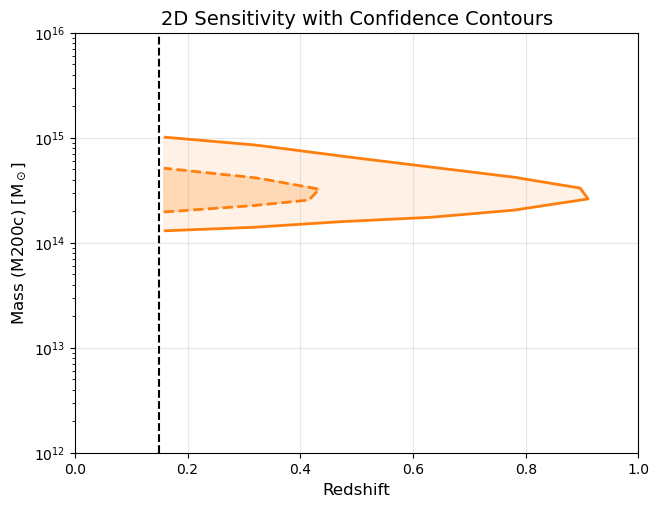

In [35]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot(2, 2, 1)

contourf_68 = ax1.contourf(z_grid, mass_grid, pdf2d, 
                           levels=[thresholds[0], pdf_2d.max()], 
                           colors=['C1'], alpha=0.3)
contourf_95 = ax1.contourf(z_grid, mass_grid, pdf2d, 
                           levels=[thresholds[1], thresholds[0]], 
                           colors=['C1'], alpha=0.1)


contour_68 = ax1.contour(z_grid, mass_grid, pdf2d, 
                         levels=[thresholds[0]], 
                         colors=['C1'], linewidths=2, linestyles='--')
contour_95 = ax1.contour(z_grid, mass_grid, pdf2d, 
                         levels=[thresholds[1]], 
                         colors=['C1'], linewidths=2, linestyles='-')



ax1.set_xlabel('Redshift', fontsize=12)
ax1.set_ylabel('Mass (M200c) [M$_\odot$]', fontsize=12)
ax1.set_title('2D Sensitivity with Confidence Contours', fontsize=14)
ax1.set_yscale('log')
ax1.set_xlim(0,1)
ax1.set_ylim(1e12,1e16)
ax1.axvline(0.15, color = 'k', ls = '--')
ax1.grid(True, alpha=0.3)

plt.show()